### lstm_predictor_project2_finetune1.ipynb - 3 yrs AAPL data - LSTM. This will use the fine tuning by using the keras tuner

# LSTM Stock Predictor Using Closing Prices

## Data Preparation

In this section, we will prepare the training and testing data for the LSTM model.

We will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the `X` and `y` values
4. Reshape the `X_train` and `X_test` data for the model.

**Note:** The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [1]:
!pip install yfinance
!pip install mplfinance
!pip install keras-tuner

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline
import yfinance as yf
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.dates as mpl_dates
from datetime import date, timedelta
import calendar
from datetime import datetime

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [1]:
Set the random seed for reproducibility
Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

SyntaxError: ignored

### Data Loading

In this activity, we will use closing prices from different stocks to make predictions of future closing prices based on the temporal data of each stock.

In [6]:
#set ticker
appl=yf.Ticker("AAPL")

In [7]:
# get stock info
appl.info

# get historical market data
hist = appl.history(period="max")

In [8]:
#download data
df = yf.download("AAPL",
                   start="2018-07-04", 
                   end="2021-07-09",
                   period = "1d"
                  )

[*********************100%***********************]  1 of 1 completed


In [9]:
# # Load the stocks data
# df = pd.read_csv(
#     Path("../Resources/stock_data.csv"),
#     index_col="date",
#     infer_datetime_format=True,
#     parse_dates=True,
# )
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-07-05,46.314999,46.602501,46.070000,46.349998,44.814629,66416800
2018-07-06,46.355000,47.107498,46.299999,46.992500,45.435848,69940800
2018-07-09,47.375000,47.669998,47.325001,47.645000,46.066730,79026400
2018-07-10,47.677502,47.820000,47.544998,47.587502,46.011139,63756400
2018-07-11,47.125000,47.445000,46.902500,46.970001,45.414093,75326000
2018-07-12,47.382500,47.852501,47.327499,47.757500,46.175507,72164400
2018-07-13,47.770000,47.959999,47.724998,47.832500,46.248024,50055600
2018-07-16,47.880001,48.162498,47.605000,47.727501,46.146507,60172400
2018-07-17,47.437500,47.967499,47.299999,47.862499,46.277035,62138000


In [10]:
#df.to_csv('content/test-aapl.csv', index=True)
#! echo "Welcome to Neptune" > file.txt
#run['content/sample'].upload('file.txt') 

### Creating the Features `X` and Target `y` Data

The first step towards preparing the data is to create the input features vectors `X` and the target vector `y`. We will use the `window_data()` function to create these vectors.

This function chunks the data up with a rolling window of _X<sub>t</sub> - window_ to predict _X<sub>t</sub>_.

The function returns two `numpy` arrays:

* `X`: The input features vectors.

* `y`: The target vector.

The function has the following parameters:

* `df`: The original DataFrame with the time series data.

* `window`: The window size in days of previous closing prices that will be used for the prediction.

* `feature_col_number`: The column number from the original DataFrame where the features are located.

* `target_col_number`: The column number from the original DataFrame where the target is located.

In [11]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In the forthcoming activities, we will predict closing prices using a `5` days windows of previous _T-Bonds_ closing prices, so that, we will create the `X` and `y` vectors by calling the `window_data` function and defining a window size of `5` and setting the features and target column numbers to `2` (this is the column with the _T-Bonds_ closing prices).

In [12]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 5

feature_column = 3
target_column = 3
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[46.34999847 46.99250031 47.64500046 47.58750153 46.97000122]
 [46.99250031 47.64500046 47.58750153 46.97000122 47.75749969]
 [47.64500046 47.58750153 46.97000122 47.75749969 47.83250046]
 [47.58750153 46.97000122 47.75749969 47.83250046 47.72750092]
 [46.97000122 47.75749969 47.83250046 47.72750092 47.86249924]] 

y sample values:
[[47.75749969]
 [47.83250046]
 [47.72750092]
 [47.86249924]
 [47.59999847]]


### Splitting Data Between Training and Testing Sets

To avoid the dataset being randomized, we will manually split the data using array slicing.

In [13]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [14]:
len(X)

753

In [15]:
split

527

In [16]:
X_train

array([[ 46.34999847,  46.99250031,  47.64500046,  47.58750153,
         46.97000122],
       [ 46.99250031,  47.64500046,  47.58750153,  46.97000122,
         47.75749969],
       [ 47.64500046,  47.58750153,  46.97000122,  47.75749969,
         47.83250046],
       ...,
       [109.66500092, 110.0625    , 113.90249634, 111.11250305,
        112.72750092],
       [110.0625    , 113.90249634, 111.11250305, 112.72750092,
        109.375     ],
       [113.90249634, 111.11250305, 112.72750092, 109.375     ,
        113.01000214]])

### Scaling Data with `MinMaxScaler`

Once the training and test datasets are created, we need to scale the data before training the LSTM model. We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.

Note that we scale both features and target sets.

In [17]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [18]:
X_train

array([[0.1003833 , 0.10635381, 0.11241723, 0.11188292, 0.10477195],
       [0.10635381, 0.11241723, 0.11188292, 0.10614473, 0.11199522],
       [0.11241723, 0.11188292, 0.10614473, 0.11346264, 0.11268315],
       ...,
       [0.68874432, 0.69243812, 0.72812167, 0.70219538, 0.70792722],
       [0.69243812, 0.72812167, 0.70219538, 0.71720291, 0.67717668],
       [0.72812167, 0.70219538, 0.71720291, 0.68604946, 0.71051844]])

### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that we need to reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`.

Both sets, training, and testing are reshaped.

In [19]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.1003833 ]
  [0.10635381]
  [0.11241723]
  [0.11188292]
  [0.10477195]]

 [[0.10635381]
  [0.11241723]
  [0.11188292]
  [0.10614473]
  [0.11199522]]

 [[0.11241723]
  [0.11188292]
  [0.10614473]
  [0.11346264]
  [0.11268315]]

 [[0.11188292]
  [0.10614473]
  [0.11346264]
  [0.1141596 ]
  [0.11172005]]

 [[0.10614473]
  [0.11346264]
  [0.1141596 ]
  [0.11318388]
  [0.11295831]]] 

X_test sample values:
[[[0.70219538]
  [0.71720291]
  [0.68604946]
  [0.71982808]
  [0.72886328]]

 [[0.71720291]
  [0.68604946]
  [0.71982808]
  [0.73841328]
  [0.7279231 ]]

 [[0.68604946]
  [0.71982808]
  [0.73841328]
  [0.73746078]
  [0.72517134]]

 [[0.71982808]
  [0.73841328]
  [0.73746078]
  [0.73467297]
  [0.73393102]]

 [[0.73841328]
  [0.73746078]
  [0.73467297]
  [0.74354742]
  [0.73526099]]]


In [20]:
X_train.shape

(527, 5, 1)

In [21]:
X_test.shape

(226, 5, 1)

In [22]:
y_train.shape

(527, 1)

In [23]:
y_test.shape

(226, 1)

---

## Build and Train the LSTM RNN

In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

We will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model to the training data.

### Importing the Keras Modules

The LSTM RNN model in Keras uses the `Sequential` model and the `LSTM` layer as we did before. However, there is a new type of layer called `Dropout`.

* `Dropout`: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [24]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN Model Structure

To create an LSTM RNN model, we will add `LSTM` layers. The `return_sequences` parameter needs to set to `True` every time we add a new `LSTM` layer, excluding the final layer. The `input_shape` is the number of time steps and the number of indicators

After each `LSTM` layer, we add a `Dropout` layer to prevent overfitting. The parameter passed to the `Dropout` layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of `0.2`, it means that on each epoch we will randomly drop `20%` of the units.

The number of units in each `LSTM` layers, is equal to the size of the time window, in this demo, we are taking five previous `T-Bons` closing price to predict the next closing price.

In [25]:
# # Define the LSTM RNN model.
# model = Sequential()

# number_units = 5
# dropout_fraction = 0.2

# # Layer 1
# model.add(LSTM(
#     units=number_units,
#     return_sequences=True,
#     input_shape=(X_train.shape[1], 1))
#     )
# model.add(Dropout(dropout_fraction))
# # Layer 2
# model.add(LSTM(units=number_units, return_sequences=True))
# model.add(Dropout(dropout_fraction))
# # Layer 3
# model.add(LSTM(units=number_units))
# model.add(Dropout(dropout_fraction))
# # Output layer
# model.add(Dense(1))

In [26]:
def build_model(hp):
    dropout_fraction = 0.2
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        # model.add(layers.Dense(units=hp.Int('units_' + str(i),
        #                                     min_value=32,
        #                                     max_value=512,
        #                                     step=32),
        #                        activation='relu'))

        # Layer 1 
        model.add(LSTM( units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),  return_sequences=True, 
                       input_shape=(X_train.shape[1], 1)) )
        model.add(Dropout(dropout_fraction))


    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])
    return model

In [27]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    project_name='Apple')

INFO:tensorflow:Reloading Oracle from existing project project/Apple/oracle.json
INFO:tensorflow:Reloading Tuner from project/Apple/tuner0.json


In [28]:
# tuner.search_space_summary()

### Compiling the LSTM RNN Model

We will compile the model, using the `adam` optimizer, as loss function, we will use `mean_square_error` since the value we want to predict is continuous.

In [29]:
# Compile the model
#model.compile(optimizer="adam", loss="mean_squared_error", metrics=['accuracy'])

In [30]:
# Summarize the model
#model.summary()

### Training the Model

Once the model is defined, we train (fit) the model using `10` epochs. Since we are working with time-series data, it's important to set `shuffle=False` since it's necessary to keep the sequential order of the data.

We can experiment with the `batch_size` parameter; however, smaller batch size is recommended; in this demo, we will use a `batch_size=1`.

In [31]:
# Train the model
#model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

In [32]:
# tuner.search(X_train, y_train,
#              epochs=5,
#              validation_data=(X_test, y_test))

In [33]:
# tuner.results_summary()

In [34]:
# Define the LSTM RNN model based on Tuner recommendation
model2 = Sequential()

#number_units = 16
dropout_fraction = 0.2

# Layer 1
model2.add(LSTM( units= 256, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model2.add(Dropout(dropout_fraction))
# Layer 2
model2.add(LSTM( units= 448, return_sequences=True))
model2.add(Dropout(dropout_fraction))
# Layer 3
model2.add(LSTM( units= 192, return_sequences=True, ))
model2.add(Dropout(dropout_fraction))
# Layer 4
model2.add(LSTM( units= 320, return_sequences=True, ))
model2.add(Dropout(dropout_fraction))
# Layer 5
model2.add(LSTM( units= 480, return_sequences=True, ))
model2.add(Dropout(dropout_fraction))
# Layer 6
model2.add(LSTM( units= 96 ))
model2.add(Dropout(dropout_fraction))
# # Layer 7
# model2.add(LSTM( units= 128, return_sequences=True, ))
# model2.add(Dropout(dropout_fraction))
# # Layer 8
# model2.add(LSTM( units= 480, return_sequences=True, ))
# model2.add(Dropout(dropout_fraction))
# # Layer 9
# model2.add(LSTM( units= 288, return_sequences=True, ))
# model2.add(Dropout(dropout_fraction))
# # Layer 10
# model2.add(LSTM( units= 160, return_sequences=True, ))
# model2.add(Dropout(dropout_fraction))
# # Layer 11
# model2.add(LSTM( units= 416, return_sequences=True, ))
# model2.add(Dropout(dropout_fraction))
# # Layer 12
# model2.add(LSTM( units= 384, return_sequences=True, ))
# model2.add(Dropout(dropout_fraction))
# # Layer 13
# model2.add(LSTM( units= 160, return_sequences=True, ))
# model2.add(Dropout(dropout_fraction))
# # Layer 14
# model2.add(LSTM( units= 352, return_sequences=True, ))
# model2.add(Dropout(dropout_fraction))
# # Layer 15
# model2.add(LSTM( units= 160, return_sequences=True, ))
# model2.add(Dropout(dropout_fraction))
# Layer 16
# model2.add(LSTM( units= 192, ))
# model2.add(Dropout(dropout_fraction))


# # Output layer
model2.add(Dense(1))
#model2.add(layers.Dense(1, activation='linear'))


In [35]:
model2.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error'])

In [36]:
# Summarize the model
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 256)            264192    
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 448)            1263360   
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 448)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 192)            492288    
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 192)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 5, 320)           

In [37]:
# Train the model
model2.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
527/527 [==============================] - 12s 11ms/step - loss: 0.0307 - mean_absolute_error: 0.0307
Epoch 2/10
527/527 [==============================] - 6s 11ms/step - loss: 0.0411 - mean_absolute_error: 0.0411
Epoch 3/10
527/527 [==============================] - 6s 11ms/step - loss: 0.0431 - mean_absolute_error: 0.0431
Epoch 4/10
527/527 [==============================] - 5s 10ms/step - loss: 0.0564 - mean_absolute_error: 0.0564
Epoch 5/10
527/527 [==============================] - 5s 10ms/step - loss: 0.0505 - mean_absolute_error: 0.0505
Epoch 6/10
527/527 [==============================] - 5s 9ms/step - loss: 0.0409 - mean_absolute_error: 0.0409
Epoch 7/10
527/527 [==============================] - 5s 9ms/step - loss: 0.0469 - mean_absolute_error: 0.0469
Epoch 8/10
527/527 [==============================] - 5s 10ms/step - loss: 0.0583 - mean_absolute_error: 0.0583
Epoch 9/10
527/527 [==============================] - 5s 10ms/step - loss: 0.0625 - mean_absolute_error: 

---
## Model Performance

In this section, we will evaluate the model using the test data. 

We will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of real (`y_test`) vs predicted values.

4. Plot the Real vs predicted values as a line chart.

### Evaluate the Model

It's time to evaluate our model to assess its performance. We will use the `evaluate` method using the testing data.

In [38]:
# Evaluate the model
model2.evaluate(X_test, y_test)

8/8 [==============================] - 2s 6ms/step - loss: 0.2972 - mean_absolute_error: 0.2972


[0.2972034811973572, 0.2972034811973572]

### Making Predictions

We will make some closing price predictions using our brand new LSTM RNN model and our testing data.

In [39]:
# Make some predictions
predicted = model2.predict(X_test)

In [40]:
predicted.shape

(226, 1)

In [41]:
predicted = predicted.reshape(226,1)

In [42]:
predicted.shape

(226, 1)

In [43]:
X_test.shape

(226, 5, 1)

In [44]:
y_test.shape

(226, 1)

Since we scaled the original values using the `MinMaxScaler`, we need to recover the original prices to better understand the predictions.

We will use the `inverse_transform()` method of the scaler to decode the scaled values to their original scale.

In [45]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

### Plotting Predicted Vs. Real Prices

To plot the predicted vs. the real values, we will create a DataFrame.

In [46]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
Date,,
2020-08-14,114.907501,92.708496
2020-08-17,114.607498,92.708473
2020-08-18,115.562500,92.708519
2020-08-19,115.707497,92.708435
2020-08-20,118.275002,92.708397


In [47]:
stocks.tail()

,Real,Predicted
Date,,
2021-07-01,137.270004,92.707909
2021-07-02,139.960007,92.707893
2021-07-06,142.020004,92.707855
2021-07-07,144.570007,92.707825
2021-07-08,143.240005,92.707802


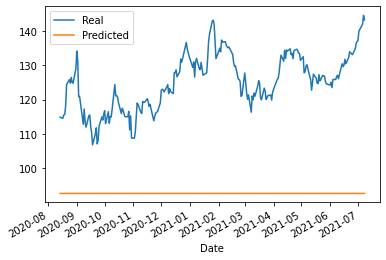

In [48]:
# Plot the real vs predicted prices as a line chart
stocks.plot()